# Profiling KMeans with onnxruntime

The notebook profiles the execution of an ONNX graph built from a *KMeans* model and executed with *onnxruntime*.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

In [3]:
%load_ext mlprodict

## Builds a KMeans

In [4]:
from sklearn.datasets import make_classification
X, y = make_classification(100000)

In [5]:
from sklearn.cluster import KMeans
km = KMeans(max_iter=10)
km.fit(X)

KMeans(max_iter=10)

In [6]:
import numpy
from mlprodict.onnx_conv import to_onnx
onx = to_onnx(km, X[:1].astype(numpy.float32))

In [7]:
%onnxview onx

## Json

Another way to look into a model.

In [8]:
from mlprodict.onnxrt import OnnxInference

oinf = OnnxInference(onx)
js = oinf.to_json()

In [9]:
import json
from io import StringIO
from jyquickhelper import JSONJS
JSONJS(json.load(StringIO(oinf.to_json())))

## Profiling

In [10]:
from mlprodict.onnxrt import OnnxInference

oinf = OnnxInference(onx, runtime="onnxruntime1",
                     runtime_options={"enable_profiling": True})

In [11]:
for i in range(0, 111):
    oinf.run({"X": X.astype(numpy.float32)})

In [12]:
df = oinf.get_profiling(as_df=True)
df

,cat,pid,tid,dur,ts,ph,name,args_op_name,args_provider,args_graph_index,args_parameter_size,args_exec_plan_index,args_activation_size,args_output_size
0,Session,504784,424180,772,21,X,model_loading_array,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Session,504784,424180,4864,850,X,session_initialization,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Node,504784,424180,4,28293,X,Re_ReduceSumSquare_fence_before,ReduceSumSquare,NaN,NaN,NaN,NaN,NaN,NaN
3,Node,504784,424180,4708,28305,X,Re_ReduceSumSquare_kernel_time,ReduceSumSquare,CPUExecutionProvider,0,0,0,8000000,400000
4,Node,504784,424180,0,33104,X,Re_ReduceSumSquare_fence_after,ReduceSumSquare,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,Node,504784,424180,0,2092121,X,Ar_ArgMin_fence_before,ArgMin,NaN,NaN,NaN,NaN,NaN,NaN
2551,Node,504784,424180,3274,2092122,X,Ar_ArgMin_kernel_time,ArgMin,CPUExecutionProvider,5,0,5,3200000,800000
2552,Node,504784,424180,0,2095401,X,Ar_ArgMin_fence_after,ArgMin,NaN,NaN,NaN,NaN,NaN,NaN
2553,Session,504784,424180,11353,2084051,X,SequentialExecutor::Execute,NaN,NaN,NaN,NaN,NaN,NaN,NaN


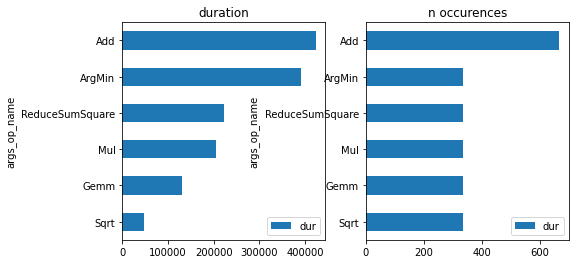

In [13]:
import matplotlib.pyplot as plt
gr_dur = df[['dur', "args_op_name"]].groupby("args_op_name").sum().sort_values('dur')
gr_n = df[['dur', "args_op_name"]].groupby("args_op_name").count().sort_values('dur')
gr_n = gr_n.loc[gr_dur.index, :]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
gr_dur.plot.barh(ax=ax[0])
gr_n.plot.barh(ax=ax[1])
ax[0].set_title("duration")
ax[1].set_title("n occurences");

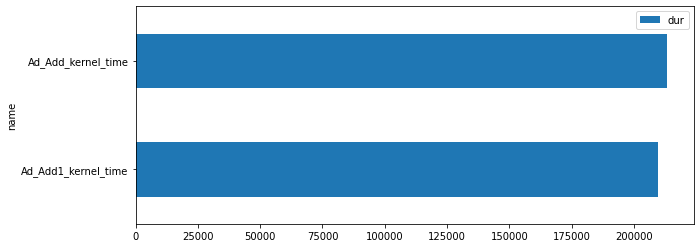

In [14]:
gr2 = df.loc[(df.args_op_name == 'Add') & (df.dur > 10), ['dur', "name"]].groupby("name").sum().sort_values('dur')
gr2.plot.barh(figsize=(10, 4));

## onnxruntime

In [15]:
from onnxruntime import InferenceSession, RunOptions, SessionOptions
so = SessionOptions()
so.enable_profiling = True
sess = InferenceSession(onx.SerializeToString(), so)

In [16]:
for i in range(0, 111):
    sess.run(None, {'X': X.astype(numpy.float32)}, )

In [17]:
prof = sess.end_profiling()
prof

'onnxruntime_profile__2021-03-18_23-16-39.json'

In [18]:
with open(prof, "r") as f:
    js = json.load(f)
    
js[:3]

[{'cat': 'Session',
  'pid': 504784,
  'tid': 424180,
  'dur': 353,
  'ts': 6,
  'ph': 'X',
  'name': 'model_loading_array',
  'args': {}},
 {'cat': 'Session',
  'pid': 504784,
  'tid': 424180,
  'dur': 3921,
  'ts': 393,
  'ph': 'X',
  'name': 'session_initialization',
  'args': {}},
 {'cat': 'Node',
  'pid': 504784,
  'tid': 424180,
  'dur': 1,
  'ts': 37730,
  'ph': 'X',
  'name': 'Re_ReduceSumSquare_fence_before',
  'args': {'op_name': 'ReduceSumSquare'}}]

In [19]:
from pandas import DataFrame
from mlprodict.onnxrt.ops_whole.session import OnnxWholeSession

df = DataFrame(OnnxWholeSession.process_profiling(js))
df

,cat,pid,tid,dur,ts,ph,name,args_op_name,args_provider,args_graph_index,args_parameter_size,args_exec_plan_index,args_activation_size,args_output_size
0,Session,504784,424180,353,6,X,model_loading_array,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Session,504784,424180,3921,393,X,session_initialization,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Node,504784,424180,1,37730,X,Re_ReduceSumSquare_fence_before,ReduceSumSquare,NaN,NaN,NaN,NaN,NaN,NaN
3,Node,504784,424180,3118,37737,X,Re_ReduceSumSquare_kernel_time,ReduceSumSquare,CPUExecutionProvider,0,0,0,8000000,400000
4,Node,504784,424180,0,40868,X,Re_ReduceSumSquare_fence_after,ReduceSumSquare,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,Node,504784,424180,0,2038167,X,Ar_ArgMin_fence_before,ArgMin,NaN,NaN,NaN,NaN,NaN,NaN
2551,Node,504784,424180,3276,2038168,X,Ar_ArgMin_kernel_time,ArgMin,CPUExecutionProvider,5,0,5,3200000,800000
2552,Node,504784,424180,0,2041449,X,Ar_ArgMin_fence_after,ArgMin,NaN,NaN,NaN,NaN,NaN,NaN
2553,Session,504784,424180,11386,2030066,X,SequentialExecutor::Execute,NaN,NaN,NaN,NaN,NaN,NaN,NaN
